# Dissipation and Dispersion Analysis
## Wave Equation — Theta Method & Newmark Method

We analyse the **dissipation** (energy loss) and **dispersion**
(true solution vs our approzimation) introduced by five fully-discrete schemes for the wave
equation on $\Omega = [0,1]^2$ with homogeneous Dirichlet BCs:

| Scheme | Parameters |
|--------|------------|
| Theta FE (Forward Euler) | $\theta = 0$ |
| Theta CN (Crank–Nicolson) | $\theta = 0.5$ |
| Theta BE (Backward Euler) | $\theta = 1$ |
| Newmark CD (Central Difference) | $\beta = 0,\; \gamma = 0.5$ |
| Newmark AA (Average Acceleration) | $\beta = 0.25,\; \gamma = 0.5$ |

**Test case** — standing mode with known exact solution:
$$u(x,y,t) = \cos\!\bigl(\sqrt{2}\,\pi\,t\bigr)\,\sin(\pi x)\,\sin(\pi y), \qquad \omega_{\mathrm{exact}} = \sqrt{2}\,\pi$$

The spatial mesh is fixed, and $\Delta t$
is varied.

### Approach
1. **Dissipation** is measured via the discrete energy $E^n = \tfrac12(\mathbf{v}^T M \mathbf{v} + \mathbf{u}^T A \mathbf{u})$. The exact solution conserves energy, so $E(T)/E(0) < 1$ reveals numerical dissipation. With no dissipation we should see instead that $E(T)/E(0) = 1$.
2. **Dispersion** is measured by comparing the numerical solution at the domain centre $(0.5, 0.5)$ with the exact solution $\cos(\sqrt{2}\,\pi\,t)$. Phase errors cause the two curves to drift apart as $t$ increases.

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Apply seaborn theme globally
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams.update({"figure.figsize": (12, 5), "grid.alpha": 0.3})

# Divergence-clipping thresholds — series are truncated at first exceedance
ENERGY_CLIP = 1.25   # |E(t)/E(0)| > this → diverged
PROBE_CLIP  = 1.25    # |u_probe|   > this → diverged

# Exact solution parameters
OMEGA_EXACT = np.sqrt(2) * np.pi   # rad/s

# Sequential colormap for dt values (small dt → dark, large dt → bright)
DT_CMAP = "plasma_r"
# Clip the colormap to avoid near-white colors for small values.
CMAP_LOW  = 0.2 
CMAP_HIGH = 1.0 


# Scheme labels for subplot titles
SCHEME_LABELS = {
    "theta-0.0":    r"$\theta$-FE ($\theta=0$)",
    "theta-0.5":    r"$\theta$-CN ($\theta=0.5$)",
    "theta-1.0":    r"$\theta$-BE ($\theta=1$)",
    "newmark-0.00": r"Newmark CD ($\beta=0$)",
    "newmark-0.25": r"Newmark AA ($\beta=0.25$)",
}

# Directories — adjust if needed
SCRIPT_DIR = Path("../scripts").resolve()
DATA_DIR   = Path("data").resolve()
# FIG_DIR    = Path("figures/dissipation-dispersion").resolve()
# FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"Script dir:  {SCRIPT_DIR}")
print(f"Data dir:    {DATA_DIR}")
# print(f"Figures dir: {FIG_DIR}")
print("Setup OK.")

Script dir:  /home/ghi/Documents/HPC-PoliMi/NMPDE/labs/wave-equation/scripts
Data dir:    /home/ghi/Documents/HPC-PoliMi/NMPDE/labs/wave-equation/analysis/data
Setup OK.


## 2. Load Simulation Data

We load the time-series produced by `scripts/dissipation_dispersion_sweep.py`:
- **`dissdisp-energy-series/`** — per-run energy time-series $E(t)$
- **`dissdisp-probe-series/`** — per-run point-probe time-series $u_h(0.5, 0.5, t)$

In [45]:
# ================================================================
# Load per-run energy and probe time-series
# ================================================================

energy_dirs = sorted(DATA_DIR.glob("dissdisp-energy-series*"))
probe_dirs  = sorted(DATA_DIR.glob("dissdisp-probe-series*"))

energy_series = {}  # key: (scheme, dt) -> DataFrame(time, energy)
probe_series  = {}  # key: (scheme, dt) -> DataFrame(time, u_probe)

if energy_dirs:
    edir = energy_dirs[-1]
    for f in sorted(edir.glob("*.csv")):
        # filename: theta-0.5_dt0.005.csv
        parts = f.stem.split("_dt")
        if len(parts) == 2:
            scheme = parts[0]
            dt_val = float(parts[1])
            energy_series[(scheme, dt_val)] = pd.read_csv(f)
    print(f"Loaded {len(energy_series)} energy time-series from {edir.name}")
else:
    print("WARNING: No energy time-series directory found.")

if probe_dirs:
    pdir = probe_dirs[-1]
    for f in sorted(pdir.glob("*.csv")):
        parts = f.stem.split("_dt")
        if len(parts) == 2:
            scheme = parts[0]
            dt_val = float(parts[1])
            probe_series[(scheme, dt_val)] = pd.read_csv(f)
    print(f"Loaded {len(probe_series)} probe time-series from {pdir.name}")
else:
    print("WARNING: No probe time-series directory found.")

Loaded 47 energy time-series from dissdisp-energy-series
Loaded 47 probe time-series from dissdisp-probe-series


## 3. Dissipation Analysis — Energy Evolution

For a non-dissipative scheme the discrete energy $E^n = \tfrac12(\mathbf{v}^T M \mathbf{v} + \mathbf{u}^T K \mathbf{u})$ should remain constant. Any decay indicates numerical dissipation.

We expect:
- **$\theta = 0.5$** (CN) and **$\beta = 0.25$** (AA): energy-conserving → $E(T)/E(0) = 1$
- **$\theta = 1$** (BE): strong energy decay
- **$\theta = 0$** (FE) and **$\beta = 0$** (CD): energy growth (no dissipation) → unstable if CFL violated

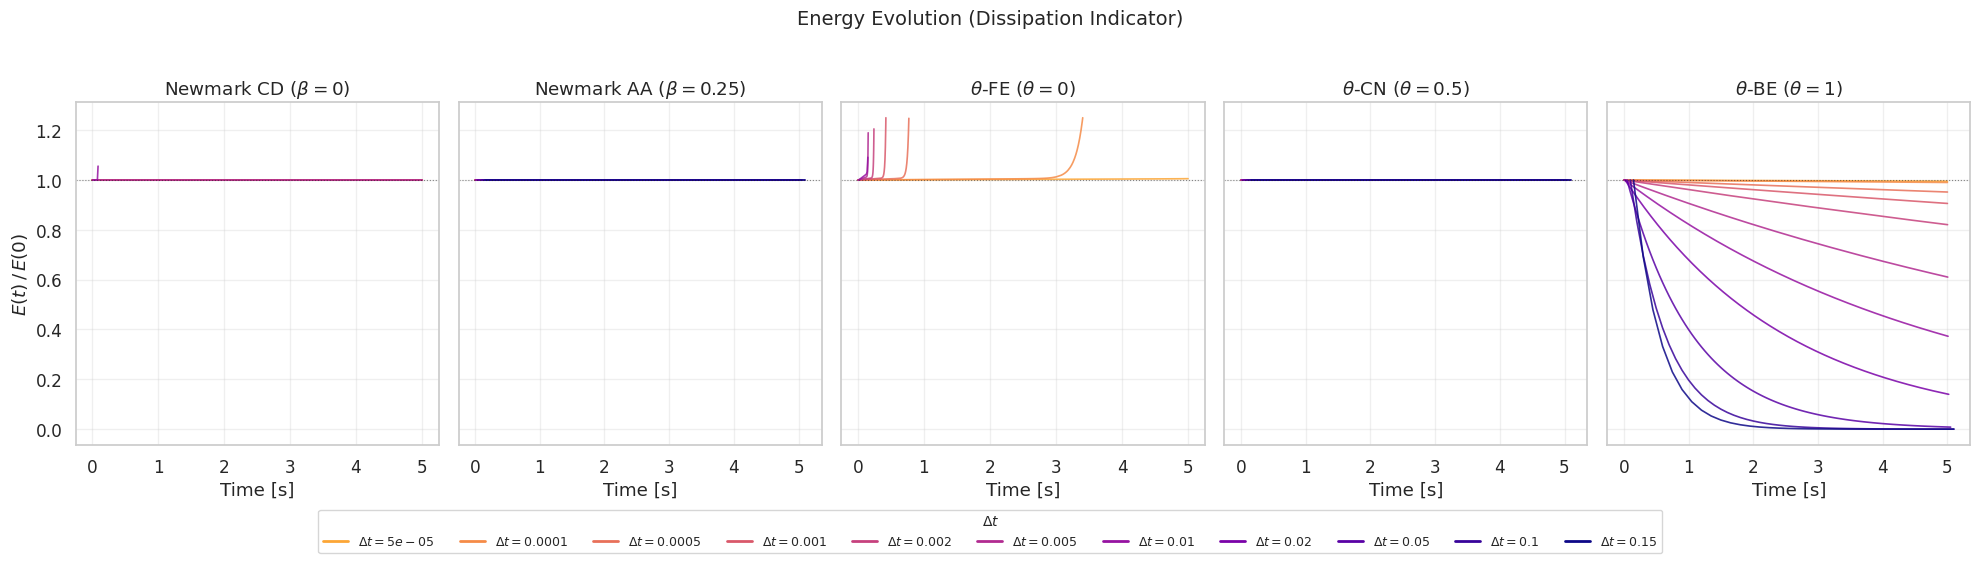

In [46]:
# ================================================================
# Plot: Normalised energy E(t)/E(0) vs time  — one subplot per scheme
# ================================================================

if energy_series:
    # Build sequential palette for Δt values (clipped to avoid light colors)
    all_dts = sorted(set(k[1] for k in energy_series))
    cmap = plt.get_cmap(DT_CMAP)
    n = len(all_dts)
    dt_palette = {f"{dt:.4g}": cmap(CMAP_LOW + (CMAP_HIGH - CMAP_LOW) * i / max(1, n - 1)) 
                  for i, dt in enumerate(all_dts)}
    dt_order = [f"{dt:.4g}" for dt in all_dts]

    schemes_present = sorted(set(k[0] for k in energy_series))
    n_schemes = len(schemes_present)
    fig, axes = plt.subplots(1, n_schemes, figsize=(4 * n_schemes, 5), sharey=True)
    if n_schemes == 1:
        axes = [axes]

    for ax, scheme in zip(axes, schemes_present):
        dt_keys = sorted([k for k in energy_series if k[0] == scheme], key=lambda x: x[1])

        rows = []
        for key in dt_keys:
            edf = energy_series[key]
            E0 = edf["energy"].iloc[0]
            if E0 > 0:
                ratio = edf["energy"] / E0
                # Truncate at first divergence to avoid y-scale distortion
                exceed = ratio.abs() > ENERGY_CLIP
                if exceed.any():
                    cut = int(exceed.values.argmax())
                    t_vals, r_vals = edf["time"].iloc[:cut].values, ratio.iloc[:cut].values
                else:
                    t_vals, r_vals = edf["time"].values, ratio.values
                rows.append(pd.DataFrame({
                    "Time [s]":  t_vals,
                    "E(t)/E(0)": r_vals,
                    "dt":        f"{key[1]:.4g}",
                }))

        if rows:
            plot_df = pd.concat(rows, ignore_index=True)
            sns.lineplot(
                data=plot_df, x="Time [s]", y="E(t)/E(0)",
                hue="dt", hue_order=dt_order,
                palette=dt_palette, ax=ax, alpha=0.85, linewidth=1.2,
                legend=False,
            )

        ax.axhline(1.0, color="k", ls=":", lw=0.8, alpha=0.5)
        ax.set_xlabel("Time [s]")
        ax.set_title(SCHEME_LABELS.get(scheme, scheme))

    axes[0].set_ylabel(r"$E(t)\,/\,E(0)$")

    # Single shared legend below the plots
    handles = [plt.Line2D([0], [0], color=dt_palette[f"{dt:.4g}"], lw=2)
               for dt in all_dts]
    labels = [rf"$\Delta t = {dt:.4g}$" for dt in all_dts]
    fig.legend(handles, labels, title=r"$\Delta t$",
               loc="lower center", bbox_to_anchor=(0.5, -0.08),
               ncol=len(all_dts), fontsize=9, title_fontsize=10, frameon=True)

    fig.suptitle("Energy Evolution (Dissipation Indicator)", fontsize=14, y=1.02)
    fig.tight_layout()
    # fig.savefig(FIG_DIR / "energy_evolution.pdf", bbox_inches="tight", dpi=150)
    # fig.savefig(FIG_DIR / "energy_evolution.png", bbox_inches="tight", dpi=150)

    plt.show()
else:
    print("No energy time-series data available. Run the sweep first.")

## 4. Dispersion Analysis — Point Probe vs Exact Solution

The most direct way to *see* dispersion is to overlay the **numerical solution at the domain centre** $(0.5, 0.5)$ with the **exact solution**:

$$u_{\text{exact}}(0.5,\,0.5,\,t) = \cos\!\bigl(\sqrt{2}\,\pi\,t\bigr)$$

since $\sin(\pi/2) = 1$.  A **dispersive** scheme produces a cosine with a slightly wrong frequency $\tilde\omega \neq \omega$, so the two curves gradually **drift out of phase**.  A **dissipative** scheme also shows **amplitude decay** on top of the phase shift.

This is meaninful since our solution is symmetric with respect to the point $(0.5, 0.5)$.

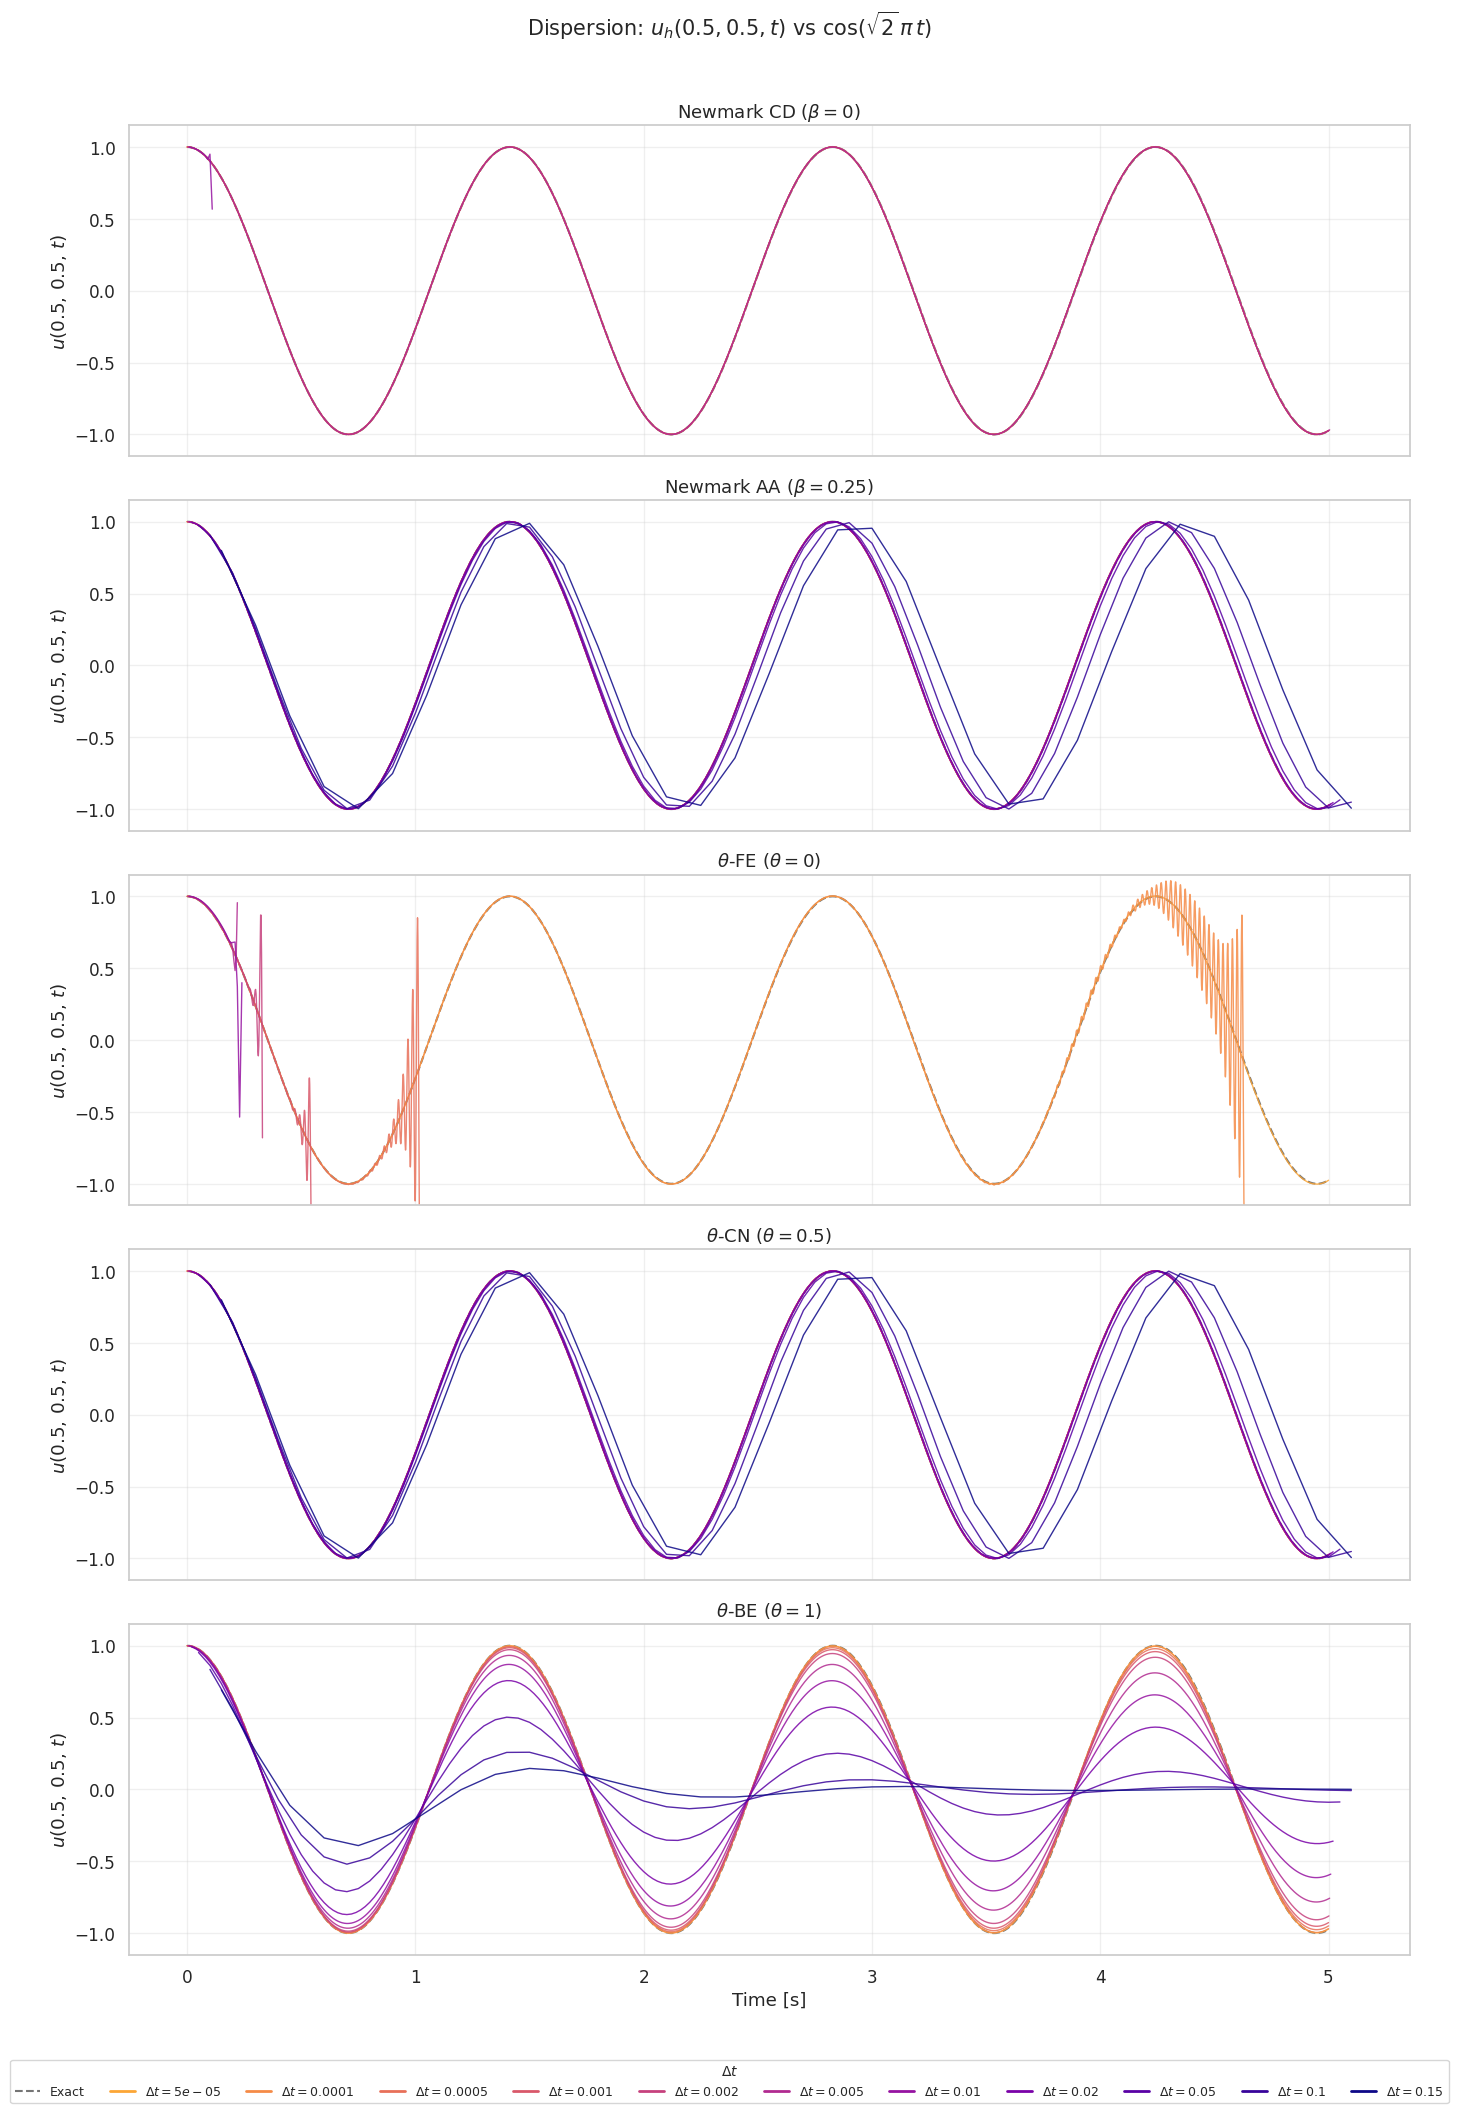

In [ ]:
# ================================================================
# Plot: u(0.5, 0.5, t) numerical vs exact — one subplot per scheme
# ================================================================

if probe_series:
    # Build sequential palette for dt values (clipped to avoid light colors)
    all_dts = sorted(set(k[1] for k in probe_series))
    cmap = plt.get_cmap(DT_CMAP)
    n = len(all_dts)
    dt_palette = {f"{dt:.4g}": cmap(CMAP_LOW + (CMAP_HIGH - CMAP_LOW) * i / max(1, n - 1)) 
                  for i, dt in enumerate(all_dts)}
    dt_order = [f"{dt:.4g}" for dt in all_dts]

    schemes_present = sorted(set(k[0] for k in probe_series))
    n_schemes = len(schemes_present)
    fig, axes = plt.subplots(n_schemes, 1, figsize=(14, 4 * n_schemes), sharex=True)
    if n_schemes == 1:
        axes = [axes]

    for ax, scheme in zip(axes, schemes_present):
        dt_keys = sorted([k for k in probe_series if k[0] == scheme], key=lambda x: x[1])

        # Exact solution (never diverges — always plot in full)
        t_fine = np.linspace(0, probe_series[dt_keys[0]]["time"].iloc[-1], 2000)
        u_exact = np.cos(OMEGA_EXACT * t_fine)
        ax.plot(t_fine, u_exact, "k--", lw=1.5, alpha=0.6, zorder=0)

        # Numerical solutions — truncate diverging ones before plotting
        rows = []
        for key in dt_keys:
            pdf = probe_series[key]
            u = pdf["u_probe"]
            exceed = u.abs() > PROBE_CLIP
            if exceed.any():
                cut = int(exceed.values.argmax())
                t_vals = pdf["time"].iloc[:cut].values
                u_vals = u.iloc[:cut].values
            else:
                t_vals = pdf["time"].values
                u_vals = u.values
            rows.append(pd.DataFrame({
                "Time [s]":       t_vals,
                "u(0.5, 0.5, t)": u_vals,
                "dt":             f"{key[1]:.4g}",
            }))

        if rows:
            plot_df = pd.concat(rows, ignore_index=True)
            sns.lineplot(
                data=plot_df, x="Time [s]", y="u(0.5, 0.5, t)",
                hue="dt", hue_order=dt_order,
                palette=dt_palette, ax=ax, alpha=0.85, linewidth=1.0,
                legend=False,
            )

        ax.set_ylabel(r"$u(0.5,\,0.5,\,t)$")
        ax.set_title(SCHEME_LABELS.get(scheme, scheme), fontsize=13)
        ax.set_ylim(-1.15, 1.15)

    axes[-1].set_xlabel("Time [s]")

    # Single shared legend below the plots (include "Exact" entry)
    handles = [plt.Line2D([0], [0], color="k", ls="--", lw=1.5, alpha=0.6)]
    labels = ["Exact"]
    handles += [plt.Line2D([0], [0], color=dt_palette[f"{dt:.4g}"], lw=2)
                for dt in all_dts]
    labels += [rf"$\Delta t = {dt:.4g}$" for dt in all_dts]
    fig.legend(handles, labels, title=r"$\Delta t$",
               loc="lower center", bbox_to_anchor=(0.5, -0.04),
               ncol=len(all_dts) + 1, fontsize=9, title_fontsize=10, frameon=True)

    fig.suptitle(r"Dispersion: $u_h(0.5,0.5,t)$ vs $\cos(\sqrt{2}\,\pi\,t)$",
                 fontsize=15, y=1.01)
    fig.tight_layout()
    # fig.savefig(FIG_DIR / "probe_vs_exact.pdf", bbox_inches="tight", dpi=150)
    # fig.savefig(FIG_DIR / "probe_vs_exact.png", bbox_inches="tight", dpi=150)

    plt.show()    
else:
    print("No probe time-series data available.")

## 5. Conclusions

- Explicit methods shows diverging behaviour. For a timestep $\Delta_t$ sufficiently small to prevent divergence we observe neither dissipation nor dispersion
- For the two methods wich are second order in time we see no dissipation, but there is a clear dispersion for higher values of the timestep. For example it is observable a shift in the peak of the wave for $\Delta_t=0.1$ and $\Delta_t=0.15$. For higher $\Delta_t$ we can't observe anymore the shape of the wave.
- Finally, Backward Euler is the more dissipative.